<div style="text-align: center"><h1>Topics – Easy Topic Modeling in Python</h1></div>

The text mining technique **Topic Modeling** has become a popular statistical method for clustering documents. This notebook introduces an user-friendly workflow, basically containing data preprocessing, an implementation of the prototypic topic model **Latent Dirichlet Allocation** (LDA) which learns the relationships between words, topics, and documents, as well as multiple visualizations to explore the trained LDA model.

In this notebook, we're relying on the LDA implementation by [Radim Řehůřek](https://radimrehurek.com) called [**gensim**](https://radimrehurek.com/gensim/). 

## First step: Installing dependencies

The following tutorial will explain how to perform LDA topic modeling with a programming library in Python. If you have not done so yet, please install all necessary libraries by executing one of the following cells.

### Windows

In [1]:
#!pip install -r requirements.txt

### macOS

In [2]:
#!pip3 install -r requirements.txt

### Linux

In [3]:
#!sudo pip3 install -r requirements.txt

## 1. Preprocessing

Let's not pay heed to any warnings right now and execute the following cell.

In [4]:
import warnings
warnings.filterwarnings("ignore") 

#### Loading modules from DARIAH-Topics library
First, we have to get access to the functionalities of the library by importing them.

In [5]:
from dariah_topics import preprocessing
from dariah_topics import doclist
from dariah_topics import meta
from dariah_topics import mallet
from dariah_topics import visualization

/usr/local/lib/python3.5/dist-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
The bokeh.charts API has moved to a separate 'bkcharts' package.

This compatibility shim will remain until Bokeh 1.0 is released.
After that, if you want to use this API you will have to install
the bkcharts package explicitly.

  warn(message)


#### Load required functions from Gensim
Furthermore, we will need some additional functions from external libraries.

In [6]:
import os
from gensim.models import LdaModel
from gensim.corpora import MmCorpus

#### Activating inline output in Jupyter notebook
The following line will just tell the notebook to show graphics in the output frames.

In [7]:
%matplotlib inline

### 1.1. Reading a corpus of documents

#### Defining the path to the corpus folder

In the present example code, we are using a folder of 'txt' documents provided with the package. For using your own corpus, change the path accordingly.

In [8]:
path = "grenzboten_sample"

#### List all documents in the folder
We begin by creating a list of all the documents in the folder specified above. That list will tell function `pre.read_from_txt()` (see below) which text documents to read.

In [9]:
pathdoclist = doclist.PathDocList(path)
document_list = pathdoclist.full_paths(as_str=True)

The current list of documents looks like this:

In [10]:
document_list

['grenzboten_sample/Grenzboten_1845_Tagebuch_52.txt',
 'grenzboten_sample/Grenzboten_1916_Kriegstagebuch_48.txt',
 'grenzboten_sample/Grenzboten_1916_Kriegstagebuch_81.txt',
 'grenzboten_sample/Grenzboten_1915_Kriegstagebuch_73.txt',
 'grenzboten_sample/Grenzboten_1914_Kriegstagebuch_97.txt',
 'grenzboten_sample/Grenzboten_1846_Tagebuch_88.txt',
 'grenzboten_sample/Grenzboten_1844_Tagebuch_56.txt',
 'grenzboten_sample/Grenzboten_1844_Tagebuch_77.txt',
 'grenzboten_sample/Grenzboten_1916_Kriegstagebuch_49.txt',
 'grenzboten_sample/Grenzboten_1846_Tagebuch_96.txt',
 'grenzboten_sample/Grenzboten_1846_Tagebuch_82.txt',
 'grenzboten_sample/Grenzboten_1844_Tagebuch_88.txt',
 'grenzboten_sample/Grenzboten_1915_Kriegstagebuch_39.txt',
 'grenzboten_sample/Grenzboten_1915_Kriegstagebuch_94.txt',
 'grenzboten_sample/Grenzboten_1914_Kriegstagebuch_37.txt',
 'grenzboten_sample/Grenzboten_1845_Tagebuch_81.txt',
 'grenzboten_sample/Grenzboten_1845_Tagebuch_93.txt',
 'grenzboten_sample/Grenzboten_191

**Alternatively**, if we want to use other documents, or just a selction of those in the specified folder, we can define our own `doclist` by creating a list of strings containing paths to text files. For example, to use only the texts from 1916, we would define the list as

`
    doclist = ['grenzboten_sample/grenzboten_1916_Kriegstagebuch_41.txt',
           'grenzboten_sample/grenzboten_1916_Kriegstagebuch_48.txt',
           'grenzboten_sample/grenzboten_1916_Kriegstagebuch_49.txt',
           'grenzboten_sample/grenzboten_1916_Kriegstagebuch_69.txt',
           'grenzboten_sample/grenzboten_1916_Kriegstagebuch_81.txt']
`

#### Generate document labels

In [11]:
document_labels = pathdoclist.labels()
document_labels

['Grenzboten_1845_Tagebuch_52',
 'Grenzboten_1916_Kriegstagebuch_48',
 'Grenzboten_1916_Kriegstagebuch_81',
 'Grenzboten_1915_Kriegstagebuch_73',
 'Grenzboten_1914_Kriegstagebuch_97',
 'Grenzboten_1846_Tagebuch_88',
 'Grenzboten_1844_Tagebuch_56',
 'Grenzboten_1844_Tagebuch_77',
 'Grenzboten_1916_Kriegstagebuch_49',
 'Grenzboten_1846_Tagebuch_96',
 'Grenzboten_1846_Tagebuch_82',
 'Grenzboten_1844_Tagebuch_88',
 'Grenzboten_1915_Kriegstagebuch_39',
 'Grenzboten_1915_Kriegstagebuch_94',
 'Grenzboten_1914_Kriegstagebuch_37',
 'Grenzboten_1845_Tagebuch_81',
 'Grenzboten_1845_Tagebuch_93',
 'Grenzboten_1914_Kriegstagebuch_94',
 'Grenzboten_1845_Tagebuch_62',
 'Grenzboten_1845_Tagebuch_85',
 'Grenzboten_1914_Kriegstagebuch_68',
 'Grenzboten_1844_Tagebuch_70',
 'Grenzboten_1916_Kriegstagebuch_41',
 'Grenzboten_1916_Kriegstagebuch_69',
 'Grenzboten_1846_Tagebuch_51',
 'Grenzboten_1914_Kriegstagebuch_95',
 'Grenzboten_1915_Kriegstagebuch_99',
 'Grenzboten_1846_Tagebuch_72',
 'Grenzboten_1844_Ta

#### Optional: Accessing metadata

In case you want a more structured overview of your corpus, execute the following cell:

In [12]:
metadata = meta.fn2metadata(os.path.join(path, '*.txt'))
metadata

,author,basename,filename,title
0,Grenzboten,Grenzboten_1845_Tagebuch_52,grenzboten_sample/Grenzboten_1845_Tagebuch_52.txt,1845_Tagebuch_52
1,Grenzboten,Grenzboten_1916_Kriegstagebuch_48,grenzboten_sample/Grenzboten_1916_Kriegstagebu...,1916_Kriegstagebuch_48
2,Grenzboten,Grenzboten_1916_Kriegstagebuch_81,grenzboten_sample/Grenzboten_1916_Kriegstagebu...,1916_Kriegstagebuch_81
3,Grenzboten,Grenzboten_1915_Kriegstagebuch_73,grenzboten_sample/Grenzboten_1915_Kriegstagebu...,1915_Kriegstagebuch_73
4,Grenzboten,Grenzboten_1914_Kriegstagebuch_97,grenzboten_sample/Grenzboten_1914_Kriegstagebu...,1914_Kriegstagebuch_97
5,Grenzboten,Grenzboten_1846_Tagebuch_88,grenzboten_sample/Grenzboten_1846_Tagebuch_88.txt,1846_Tagebuch_88
6,Grenzboten,Grenzboten_1844_Tagebuch_56,grenzboten_sample/Grenzboten_1844_Tagebuch_56.txt,1844_Tagebuch_56
7,Grenzboten,Grenzboten_1844_Tagebuch_77,grenzboten_sample/Grenzboten_1844_Tagebuch_77.txt,1844_Tagebuch_77
8,Grenzboten,Grenzboten_1916_Kriegstagebuch_49,grenzboten_sample/Grenzboten_1916_Kriegstagebu...,1916_Kriegstagebuch_49
9,Grenzboten,Grenzboten_1846_Tagebuch_96,grenzboten_sample/Grenzboten_1846_Tagebuch_96.txt,1846_Tagebuch_96


#### Read listed documents from folder

In [13]:
corpus = preprocessing.read_from_txt(document_list)

At this point, the corpus is generator object.

### 1.3. Tokenize corpus
Your text files will be tokenized. Tokenization is the task of cutting a stream of characters into linguistic units, simply words or, more precisely, tokens. The tokenize function the library provides is a simple unicode tokenizer. Depending on the corpus it might be useful to use an external tokenizer function, or even develop your own, since its efficiency varies with language, epoch and text type.

In [14]:
tokens = [list(preprocessing.tokenize(document)) for document in list(corpus)]

At this point, each text is represented by a list of separate token strings. If we want to look e.g. into the first text (which has the index `0` as Python starts counting at 0) and show its first 10 words/tokens (that have the indeces `0:9` accordingly) by typing:

In [15]:
tokens[0][0:9]

['eh',
 'aus',
 'kiel',
 'allgrecn-ussing',
 'antrag',
 'die',
 'kieler',
 'adresse',
 'und']

### 1.4.1 Create a document-term matrix

The LDA topic model is based on a [document-term matrix](https://en.wikipedia.org/wiki/Document-term_matrix) of the corpus. To improve performance in large corpora, the matrix describes the frequency of terms that occur in the collection. In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms.

In [16]:
doc_terms = preprocessing.create_doc_term_matrix(tokens, document_labels)
doc_terms

,die,der,und,in,den,von,zu,das,des,nicht,...,mördern,mühevolle,münch-bellinghausen,mühling,mühsame,mühsamen,müht,mül,müllers,a!s
Grenzboten_1845_Tagebuch_52,385.0,351.0,331.0,215.0,138.0,142.0,130.0,114.0,105.0,93.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1916_Kriegstagebuch_48,47.0,69.0,64.0,19.0,17.0,42.0,0.0,8.0,16.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1916_Kriegstagebuch_81,39.0,75.0,64.0,33.0,26.0,35.0,3.0,8.0,16.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1915_Kriegstagebuch_73,41.0,51.0,43.0,31.0,27.0,7.0,1.0,7.0,9.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1914_Kriegstagebuch_97,21.0,24.0,20.0,22.0,8.0,16.0,3.0,5.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1846_Tagebuch_88,126.0,118.0,116.0,62.0,43.0,44.0,46.0,45.0,20.0,37.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1844_Tagebuch_56,90.0,92.0,88.0,70.0,30.0,25.0,25.0,16.0,25.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1844_Tagebuch_77,181.0,153.0,141.0,98.0,55.0,59.0,72.0,59.0,44.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1916_Kriegstagebuch_49,80.0,86.0,81.0,21.0,34.0,23.0,1.0,14.0,29.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1846_Tagebuch_96,637.0,456.0,482.0,299.0,217.0,170.0,239.0,173.0,97.0,169.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


### 1.4.2 Create a sparse bag-of-words model

The LDA topic model is based on a bag-of-words model of the corpus. To improve performance in large corpora, actual words and document titels are replaced by indices in the actual bag-of-words model. It is therefore necessary to create dictionaries for mapping these indices in advance.

#### Create dictionaries

In [17]:
id_types = preprocessing.create_dictionary(tokens)
doc_ids = preprocessing.create_dictionary(document_labels)

#### Create matrix market

In [18]:
sparse_bow = preprocessing.create_sparse_bow(document_labels, tokens, id_types, doc_ids)

### 1.5. Feature selection and/or removal

In topic modeling, it is often usefull (if not vital) to remove some types before modeling. In this example, the 100 most frequent words and the *hapax legomena* in the corpus are listed and removed. Alternatively, the 'feature_list' containing all features to be removed from the corpus can be replaced by, or combined with an external stop word list or any other list of strings containing features we want to remove.

**Note**: For small/normal corpora using a **`doc_term_matrix` (1.5.1)** will be easier to handle. Using **`sparse_bow` (1.5.2)** is recommended for large corpora only.

### 1.5.1 Remove features from `doc_term_matrix`

#### List the 100 most frequent words

In [19]:
mfw100 = preprocessing.find_stopwords(doc_terms, 100)

These are the five most frequent words:

In [20]:
mfw100[:5]

['die', 'der', 'und', 'in', 'den']

#### List hapax legomena

In [21]:
hapax_list = preprocessing.find_hapax(doc_terms)

#### Optional: Use external stopwordlist

In [22]:
path_to_stopwordlist = "tutorial_supplementals/stopwords/en.txt"

extern_stopwords = [line.strip() for line in open(path_to_stopwordlist, 'r')]

#### Combine lists and remove content from `doc_term_matrix`

In [23]:
features = set(mfw100 + hapax_list + extern_stopwords)
doc_terms = preprocessing.remove_features(doc_terms, features)

Finally, this is how your clean corpus looks like now.

In [24]:
doc_terms

,ihr,immer,franzosen,genommen,ganz,abgewiesen,zwei,wurde,nun,ohne,...,tilemans,tausendmal,taten,geldinstitute,tatkraft,gemeinem,tausenden,teilangriffe,tendenzstück,gemeingefährlichkeitsmaßstab
Grenzboten_1845_Tagebuch_52,8.0,15.0,4.0,1.0,10.0,0.0,8.0,10.0,8.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
Grenzboten_1916_Kriegstagebuch_48,0.0,0.0,7.0,6.0,1.0,12.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1916_Kriegstagebuch_81,0.0,0.0,6.0,6.0,0.0,19.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
Grenzboten_1915_Kriegstagebuch_73,0.0,0.0,8.0,11.0,0.0,6.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1914_Kriegstagebuch_97,0.0,0.0,2.0,3.0,0.0,3.0,2.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1846_Tagebuch_88,3.0,8.0,1.0,2.0,10.0,0.0,5.0,9.0,7.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1844_Tagebuch_56,4.0,3.0,0.0,1.0,7.0,0.0,2.0,2.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1844_Tagebuch_77,7.0,7.0,0.0,1.0,4.0,0.0,4.0,6.0,5.0,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1916_Kriegstagebuch_49,0.0,0.0,12.0,17.0,1.0,11.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grenzboten_1846_Tagebuch_96,23.0,14.0,10.0,3.0,20.0,0.0,20.0,17.0,18.0,10.0,...,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.5.2 Remove features from `sparse_bow`

#### List the 100 most frequent words

In [25]:
mfw100 = preprocessing.find_stopwords(sparse_bow, mfw=100, id_types=id_types)

These are the five most frequent words:

In [26]:
mfw100[:5]

['die', 'der', 'und', 'in', 'den']

#### List hapax legomena

In [27]:
hapax_list = preprocessing.find_hapax(sparse_bow, id_types)

#### Optional: Use external stopwordlist

In [28]:
path_to_stopwordlist = "tutorial_supplementals/stopwords/en.txt"

extern_stopwords = [line.strip() for line in open(path_to_stopwordlist, 'r')]

#### Combine lists and remove content from bag-of-words model

In [29]:
features = set(mfw100 + hapax_list + extern_stopwords)
doc_terms = preprocessing.remove_features(doc_terms, features)

### 1.6. Save bag-of-words model

In [30]:
preprocessing.save_sparse_bow(sparse_bow, "corpus")

## 2. Model creation

The actual topic modeling is done with external state-of-the-art LDA implementations. In this example, we are relying on the open-source toolkit **Gensim** which was used and cited in over 400 commercial and academic applications since 2008.

### 2.1. Load corpus object

In [31]:
mm = MmCorpus("corpus.mm")

### 2.2. Rearrange dictionaries 

In [32]:
doc2id = {value : key for key, value in doc_ids.items()}
type2id = {value : key for key, value in id_types.items()}

### 2.3. Generate LDA model

We can define the number of topics we want to calculate as an argument (`num_topics`) in the function. Furthermore, the number of passes (`passes`) can be defined. A higher number of passes and interations will probably yield a better model, but also increases processing time.

**Warning: this step can take quite a while!** Meaning something between some seconds and some hours depending on corpus size and the number of passes. Our example short stories corpus should be done within a minute or two at `passes=10`.

In [33]:
%%time

model = LdaModel(corpus=mm, id2word=type2id, num_topics=10, passes=10, iterations=5000)

CPU times: user 1min, sys: 1min 5s, total: 2min 5s
Wall time: 50.8 s


### 2.4. Create document-topic matrix

The generated model object can now be translated into a human-readable document-topic matrix (that is a actually a pandas data frame) that constitutes our principle exchange format for topic modeling results. For generating the matrix from a Gensim model, we can use the following function:

In [34]:
preprocessing.gensim2dataframe(model)

,0,1,2,3,4,5,6,7,8,9
0,geehrte,überreizten,glücks,zeigt,wasser,verhindern,hengstenberg,erstürmung,versenkung,bereichern
1,geehrte,glücks,überreizten,verhindern,hengstenberg,wasser,zeigt,neuern,auffassen,ausarbeitung
2,castelgomberto,glücks,dauerhaftigkeit,geehrte,überreizten,verhindern,auffassen,steinpflaster,wasser,voller
3,wp,auszurichten,überreizten,zeigt,geehrte,glücks,jaszbereny,versenkung,wasser,hengstenberg
4,überreizten,geehrte,glücks,wasser,hengstenberg,verhindern,auffassen,kette,zeigt,neuern
5,geehrte,überreizten,glücks,wasser,verhindern,hengstenberg,neuern,hauptsächlich,auffassen,zeigt
6,glücks,geehrte,überreizten,wasser,hengstenberg,verhindern,zeigt,hauptsächlich,versenkung,auffassen
7,jaszbereny,gewiß,boelckc,gemeinnützigen,überreizten,geehrte,rönne,glücks,kraft,marokkanische
8,berein,geehrte,überreizten,voller,glücks,wasser,terroristen,hengstenberg,verhindern,genehmigt
9,glücks,geehrte,überreizten,wasser,ausarbeitung,hengstenberg,verhindern,kette,uebergabe,crasse


## 3. Model visualization and evaluation

The following matrix contains the probability per topic for each document, which we need for the visualization.

In [35]:
doc_topic = visualization.create_doc_topic(mm, model, document_labels)
doc_topic

,Grenzboten_1845_Tagebuch_52,Grenzboten_1916_Kriegstagebuch_48,Grenzboten_1916_Kriegstagebuch_81,Grenzboten_1915_Kriegstagebuch_73,Grenzboten_1914_Kriegstagebuch_97,Grenzboten_1846_Tagebuch_88,Grenzboten_1844_Tagebuch_56,Grenzboten_1844_Tagebuch_77,Grenzboten_1916_Kriegstagebuch_49,Grenzboten_1846_Tagebuch_96,...,Grenzboten_1914_Kriegstagebuch_68,Grenzboten_1844_Tagebuch_70,Grenzboten_1916_Kriegstagebuch_41,Grenzboten_1916_Kriegstagebuch_69,Grenzboten_1846_Tagebuch_51,Grenzboten_1914_Kriegstagebuch_95,Grenzboten_1915_Kriegstagebuch_99,Grenzboten_1846_Tagebuch_72,Grenzboten_1844_Tagebuch_82,Grenzboten_1915_Kriegstagebuch_33
geehrte überreizten glücks,0.703007,0.000000,0.0000,0.999697,0.789255,0.000000,0.000000,0.000000,0.787693,0.000000,...,0.000000,0.000000,0.998779,0.000000,0.999256,0.999388,0.759231,0.000000,0.584133,0.606843
geehrte glücks überreizten,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
castelgomberto glücks dauerhaftigkeit,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.211779,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
wp auszurichten überreizten,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.355898
überreizten geehrte glücks,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
geehrte überreizten glücks,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
glücks geehrte überreizten,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
jaszbereny gewiß boelckc,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.240295,0.000000,0.000000,0.000000
berein geehrte überreizten,0.296543,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
glücks geehrte überreizten,0.000000,0.999851,0.9999,0.000000,0.210389,0.999621,0.999863,0.999755,0.000000,0.999857,...,0.999943,0.999918,0.000000,0.999889,0.000000,0.000000,0.000000,0.999886,0.414886,0.036639


### 3.1. Distribution of topics

#### Distribution of topics over all documents

The distribution of topics over all documents can now be visualized in a heat map. Note: Plot will be shown in a seperate tab.

In [40]:
visualization.doc_topic_heatmap_interactive(doc_topic, title="Grenzbote")

#### Distribution of topics in a single documents

To take closer look on the topics in a single text, we can use the follwing function that shows all the topics in a text and their respective proportions. To select the document, we have to give its index to the function.

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py'>

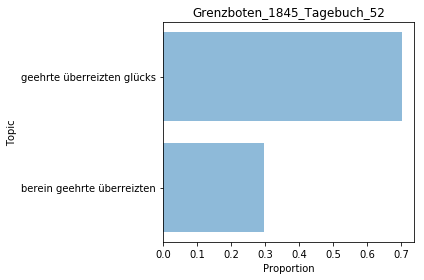

In [38]:
visualization.plot_doc_topics(doc_topic, 0)